<center>
<h2>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h2>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2020</h3>
<h3>Predicción de la Calidad de Servicio</h3>
<h3>Aprendizaje Supervisado y No Supervisado</h3>
</center>
</left>
<h4>Mentor: Martín Hunziker</h4>

[Link Mentoria](https://sites.google.com/view/mentorias2020-diplodatos/ciencia-de-datos-aplicada-en-la-distribuci%C3%B3n-de-energ%C3%ADa-el%C3%A9ctrica?authuser=0).

</left>
</left>

### Introducción

En la siguiente notebook, se presentará la consigna a seguir para el práctico de las materias Aprendizaje Supervisado y No Supervisado. 


In [1]:
# Importación de las librerías necesarias
import numpy as np
import pandas as pd
# Puede que nos sirvan también
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, Perceptron, Ridge, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_curve, auc, r2_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans

np.random.seed(0)  # Para mayor determinismo

## 1.Carga de datos

De los prácticos anteriores cargamos el dataset con las efatures georeferenciadas que calculamos.

Exporta el dataframe obtenido en el ultimo practico a un csv y cargalo como dataframe.

In [2]:
ucbt_untrd_untrs_with_metrics = pd.read_csv('./Dataset/ucbt_untrd_untrs_with_metrics_dist_v2_2.csv')

__*Sugerencia:*__ eliminar variables que no aporten información por ejemplo:


*   Indices y IDs
*   Referencias a otras tablas
*   Variables compuestas (listas, jsons, geometrias)

Identifica las variables que cumplen este criterio y eliminelas del dataset.

Eliminen la variable de salida que no van a utilizar FIC o DIC.



In [3]:
ucbt_untrd_untrs_with_metrics.columns

Index(['Unnamed: 0', 'COD_ID', 'geometry', 'CTMT', 'UNI_TR_D', 'DIC', 'FIC',
       'ENE_MED', 'ENE_MAX', 'UNI_TR_S', 'ARE_LOC', 'geometry_untrd',
       'geometry_untrs', 'EUC_DIST_UNTRS', 'EUC_DIST_CENT', 'EUC_DIST_PRIMARY',
       'EUC_DIST_SECONDARY', 'TIEMPO_MIN', 'DISTANCIA_KM', 'NODE', 'ENDNODE',
       'g_degree', 'g_avg_ndeg', 'g_pagerank', 'dist_to_trs', 'COMP', 'R', 'X',
       'impedancia', 'angulo_impedancia', 'GRU_TAR_2', 'GRU_TAR_3',
       'DIC_above', 'FIC_above'],
      dtype='object')

In [4]:
ucbt_untrd_untrs_with_metrics.drop(columns=['Unnamed: 0', 'COD_ID', 'CTMT', 'UNI_TR_D', 'NODE', 'ENDNODE', 'DIC_above', 'UNI_TR_S',
                                            'FIC_above', 'geometry', 'geometry_untrd', 'geometry_untrs'], axis=1,
                                  inplace=True)

In [8]:
ucbt_untrd_untrs_with_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3334 entries, 0 to 3333
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DIC                 3334 non-null   float64
 1   FIC                 3334 non-null   float64
 2   ENE_MED             3334 non-null   float64
 3   ENE_MAX             3334 non-null   float64
 4   ARE_LOC             3334 non-null   int64  
 5   EUC_DIST_UNTRS      3334 non-null   float64
 6   EUC_DIST_CENT       3334 non-null   float64
 7   EUC_DIST_PRIMARY    3334 non-null   float64
 8   EUC_DIST_SECONDARY  3334 non-null   float64
 9   TIEMPO_MIN          3334 non-null   float64
 10  DISTANCIA_KM        3334 non-null   float64
 11  g_degree            3334 non-null   float64
 12  g_avg_ndeg          3334 non-null   float64
 13  g_pagerank          3334 non-null   float64
 14  dist_to_trs         3334 non-null   float64
 15  COMP                3334 non-null   float64
 16  R     

## 2. Preprocesamiento y partición de datos

Siempre se recomienda partir los datos antes de realizar el preprocesamiento y guardar el pipeline de transformación para aplicar en operaciones futuras.

Sin embargo, algunas operaciones principalmente la codificación de variables puede realizarse antes de hacer la partición ya que no representa una interacción entre las filas.

Genere una partición de datos en sets de entrenamiento y validación.

In [9]:
_ds_shuff = shuffle(ucbt_untrd_untrs_with_metrics)

X = _ds_shuff[['ARE_LOC', 'GRU_TAR_2', 'GRU_TAR_3', 'ENE_MED', 'ENE_MAX',
               'EUC_DIST_UNTRS','EUC_DIST_CENT', 
               'EUC_DIST_PRIMARY', 'EUC_DIST_SECONDARY',
               'TIEMPO_MIN', 'DISTANCIA_KM', 
               'g_degree', 'g_avg_ndeg',
       'g_pagerank', 'dist_to_trs', 'COMP', 'R', 'X', 'impedancia',
       'angulo_impedancia']]

y_dic = _ds_shuff['DIC']

y_fic = _ds_shuff['FIC']

X_train, X_test, y_train_dic, y_test_dic = train_test_split(X, y_dic, test_size=0.20, random_state=42)
X_train, X_test, y_train_fic, y_test_fic = train_test_split(X, y_fic, test_size=0.20, random_state=42)



__**Recuerden:**__ *El procesamiento que debemos hacer sobre los datos esta relacionado con el algoritmo a implementar*

## 3. Preparación de datos para regresión lineal

Los algoritmos de regresion solo aceptan entradas numéricas, por lo tanto el primer paso que debemos realizar es codificar las variables categóricas numericamente.

Adicionalmente las diferencias en las dimensiones absolutas de las variables van a tener un impacto muy pronunciado en los coeficientes calculados por lo que tambien se recomienda realizar la normalizacion de las variables. 

Esto puede hacerse de varias maneras:

*   Media/Mediana y desviacion standard
*   Minimo y Maximo (Cuidado con los outliers)
*   De 1 a -1

Implemente una función o pipeline que aplique codificación de variables categóricas y luego normalización.

__**Recuerden:**__ los parametros de normalización se calculan usando únicamente los valores de entrenamiento.

#### En el práctico anterior se realizaron todas estas cosas anteriores. Por lo que el dataset ya se encuentra normalizado y las variables categóricas ya estan representadas numéricamente.

## 4. Regresión lineal simple y regularizada.

Con los datos preprocesados obtenidos en el punto anterior implemente una regresion lineal. 

Evaluación del modelo:

Para evaluar el modelo calcule R cuadrado, error medio absoluto y error medio cuadrado. Tanto de entrenamiento como de validación.

#### Procedemos a utilizar Regresion Lineal para predecir la DIC.

In [10]:
lienal_regression = LinearRegression()
lienal_regression.fit(X_train, y_train_dic)
y_predicted_dic = lienal_regression.predict(X_test)
y_predicted_train_dic = lienal_regression.predict(X_train)
print("---Set de Entrenamiento---")
print('R2 score para DIC: %.2f' % r2_score(y_train_dic, y_predicted_train_dic))
print('Error Medio Cuadrado para la DIC: %.2f' % mean_squared_error(y_train_dic, y_predicted_train_dic))
print('Error Medio Absoluto para la DIC: %.2f' % mean_absolute_error(y_train_dic, y_predicted_train_dic))
print("---Set de Test---")
print('R2 score para DIC: %.2f' % r2_score(y_test_dic, y_predicted_dic))
print('Error Medio Cuadrado para la DIC: %.2f' % mean_squared_error(y_test_dic, y_predicted_dic))
print('Error Medio Absoluto para la DIC: %.2f' % mean_absolute_error(y_test_dic, y_predicted_dic))

---Set de Entrenamiento---
R2 score para DIC: 0.46
Error Medio Cuadrado para la DIC: 293.41
Error Medio Absoluto para la DIC: 12.09
---Set de Test---
R2 score para DIC: 0.47
Error Medio Cuadrado para la DIC: 250.21
Error Medio Absoluto para la DIC: 11.15


#### Procedemos a utilizar Regresion Lineal para predecir la FIC.

In [11]:
lienal_regression.fit(X_train, y_train_fic)
y_predicted_fic = lienal_regression.predict(X_test)
y_predicted_train_fic = lienal_regression.predict(X_train)
print("---Set de Entrenamiento---")
print('R2 score para FIC: %.2f' % r2_score(y_train_fic, y_predicted_train_fic))
print('Error Medio Cuadrado para la FIC: %.2f' % mean_squared_error(y_train_fic, y_predicted_train_fic))
print('Error Medio Absoluto para la FIC: %.2f' % mean_absolute_error(y_train_fic, y_predicted_train_fic))
print("---Set de Test---")
print('R2 score para DIC: %.2f' % r2_score(y_test_dic, y_predicted_dic))
print('Error Medio Cuadrado para la FIC: %.2f' % mean_squared_error(y_test_dic, y_predicted_dic))
print('Error Medio Absoluto para la FIC: %.2f' % mean_absolute_error(y_test_dic, y_predicted_dic))

---Set de Entrenamiento---
R2 score para FIC: 0.50
Error Medio Cuadrado para la FIC: 22.44
Error Medio Absoluto para la FIC: 3.51
---Set de Test---
R2 score para DIC: 0.47
Error Medio Cuadrado para la FIC: 250.21
Error Medio Absoluto para la FIC: 11.15


### Análisis de residuos

Otro punto importante en la evaluación de los modelos de regresión, es no solo saber cuanto es el error sino como se distribuye. Para eso realizamos un análisis de residuos. Los residuos son simplemente las desviaciones de la predicción al valor real.

Primero grafique la distribucion de los residuos.

Para realizar los gráficos de los residuos, tenemos que tomar una sola dimensión de X, por lo que utilizaremos en este caso ENE_MED. Además para graficar la recta necesitamos una recta, que la conseguimos con la función linear_least_squares. En donde se le pasa por parámetro la dimensión de X y la variable dependiente "y".

Esta función linear_least_squares agarra las variables independientes y 

In [12]:
def linear_least_squares(X, y):
    X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias
    return np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T.dot(y))

def f(X, w):
    X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias: (1, x)
    return X_b.dot(w)

#### Gráfico de la dimensión de ENE_MED y la FIC.

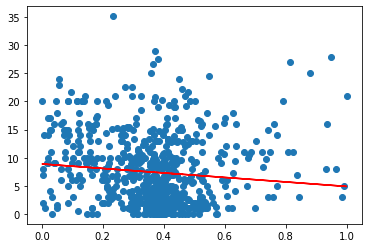

In [13]:
plt.scatter(X_test['ENE_MED'], y_test_fic)
w = linear_least_squares(X_test['ENE_MED'], y_predicted_fic)
plt.plot(X_test['ENE_MED'], f(X_test['ENE_MED'], w), color='red')
plt.show()

Los puntos azules corresponden a los valores de test de FIC con X_test['ENE_MED] en el eje de las "x". Y la linea roja corresponde a la función lineal con respecto a los Y predichos de FIC, con la entrada X_test['ENE_MED]

#### Gráfico de la dimensión de ENE_MED y la DIC.

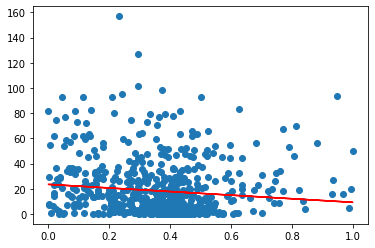

In [14]:
plt.scatter(X_test['ENE_MED'], y_test_dic)
w = linear_least_squares(X_test['ENE_MED'], y_predicted_dic)
plt.plot(X_test['ENE_MED'], f(X_test['ENE_MED'], w), color='red')
plt.show()

Los puntos azules corresponden a los valores de test de DIC con X_test[ENE_MED] en el eje de las "x". Y la linea roja corresponde a la función lineal con respecto a los Y predichos de DIC, con la entrada X_test[ENE_MED]

#### En los graficos anteriores podemos observar como se distribuye el valor de la FIC y la DIC con respecto a la ENE_MED.

Esta distribución debe estar centrada en cero y debería tender a ser simétrica.

**A continuación genere un scatter plot entre la prediccion y el error.** 

Esto debería verse principalmente como ruido, ya que no debería haber correlación entre estos valores.

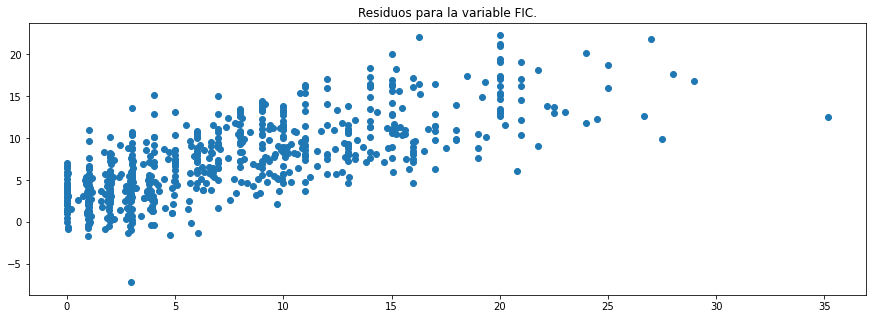

In [15]:
fig = plt.figure(figsize=(15,5))

plt.scatter(y_test_fic, y_predicted_fic)
plt.title('Residuos para la variable FIC.')
plt.show()

Los puntos azules corresponden a los valores de los residuos con respecto a la FIC.

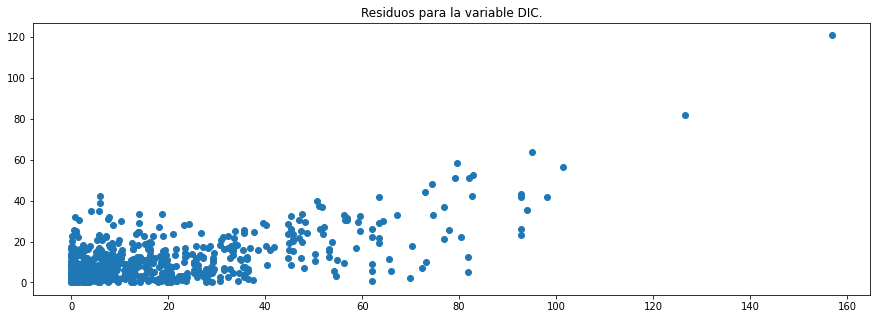

In [16]:
fig = plt.figure(figsize=(15,5))

plt.scatter(y_test_dic, abs(y_predicted_dic - y_test_dic))
plt.title('Residuos para la variable DIC.')
plt.show()

Los puntos azules corresponden a los valores de los residuos con respecto a la DIC.

Finalmente el último gráfico que realizaremos es el QQ Plot, que nos indicará la distribución del error a lo largo de los cuartiles.

**Genere un qq plot con las predicciones realizadas.**
(from statsmodels.graphics.gofplots import qqplot)


#### QQPlot para los valores predichos de la DIC.

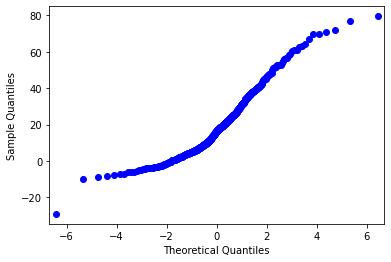

In [17]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

fig = qqplot(y_predicted_dic, stats.t, distargs=(4,))
plt.show()

#### QQPlot para los valores predichos de la FIC.

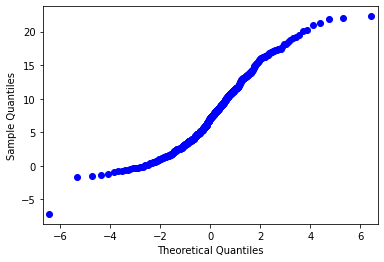

In [18]:
fig = qqplot(y_predicted_fic, stats.t, distargs=(4,))
plt.show()

En este caso los valores deben concentrarse sobre la linea diagonal.

## 5. Importancia de las variables, Regresión Lineal

En base a la arquitectura del modelo y utilizando los coeficientes del modelo, determine cuales son las 10 variables de mayor peso en el modelo y explique porque.

Las variables que utilizamos para implementar la regresión lineal son:
   - ARE_LOC
   - GRU_TAR_2
   - GRU_TAR_3
   - ENE_MED
   - ENE_MAX
   - eu_dis_untrs
   - eu_dis_nfe
   - main_r_dist
   - secondary_r_dist
   - g_degree
   - g_avg_ndeg
   - g_pagerank
   - dist_to_trs
   - COMP
   - R
   - X
   - impedancia
   - angulo_impedancia
   
 De las cuales las 10 más relevantes podríamos decir que son: 

[('impedancia', 348.4819361770808),
 ('X', 83.87802302269718),
 ('dist_to_trs', 16.649499085357526),
 ('g_pagerank', 7.589174515931664),
 ('EUC_DIST_PRIMARY', 7.234094462298121),
 ('DISTANCIA_KM', 6.290515167056874),
 ('EUC_DIST_UNTRS', 4.721046114463298),
 ('ENE_MED', 2.0547566476987242),
 ('g_avg_ndeg', 1.197735017941151),
 ('EUC_DIST_SECONDARY', -0.25510012930772386)]

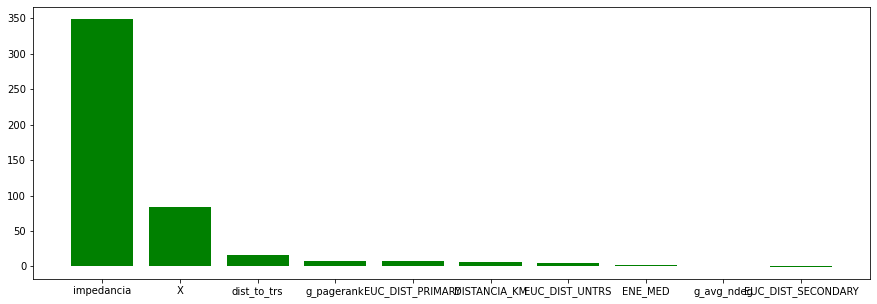

In [19]:
keys = X.columns
values = lienal_regression.coef_
dictionary = dict(zip(keys, values))
dictionary = sorted(dictionary.items(), key=lambda x: x[1], reverse=True) # Los ordenamos de mayor a menor.
features_most_important = dictionary[:10] #Nos quedamos solamente con los 10 primeros.
labels, values = zip(*features_most_important)
fig = plt.figure(figsize=(15,5))
plt.bar(labels, values, color='g')

display(features_most_important)

## 6. Preparación de datos para algoritmos basados en arboles

Otra rama muy utilizada de modelos son aquellos basados en arboles de decisión, como Bagging, Random Forrest o Boosting. En nuestro caso utilizaremos una implementacion de Boosting por gradiente denominada XGBoost que es reconocida por producir muy buenos resultados.

Dada la naturaleza de los árboles de decisión en este caso es necesario normalizar los datos. Para demostrarlo, entrene dos modelos con parametros por default, utilizando el dataset normalizado y sin normalizar.

#### Como nuestro dataset se encuentra ya normalizado (en el práctico anterior se lo normalizó), no probaremos el caso de sin normalización para XGBoost. 

In [20]:
import xgboost as xgb

In [21]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train, y_train_fic)

y_pred_fic = xgb_model.predict(X_test)

print('R2 score para FIC: %.2f' % r2_score(y_test_fic, y_pred_fic))

print('Error Medio Cuadrado para la FIC: %.2f' % np.sqrt(mean_squared_error(y_test_fic, y_pred_fic)))
print('Error Medio Absoluto para la FIC: %.2f' % mean_absolute_error(y_test_fic, y_pred_fic))

[08:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
R2 score para FIC: 0.78
Error Medio Cuadrado para la FIC: 2.92
Error Medio Absoluto para la FIC: 2.08


In [22]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train, y_train_dic)

y_pred_dic = xgb_model.predict(X_test)

print('R2 score para DIC: %.2f' % r2_score(y_test_dic, y_pred_dic))

print('Error Medio Cuadrado para la FIC: %.2f' % np.sqrt(mean_squared_error(y_test_dic, y_pred_dic)))
print('Error Medio Absoluto para la FIC: %.2f' % mean_absolute_error(y_test_dic, y_pred_dic))

[08:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
R2 score para DIC: 0.76
Error Medio Cuadrado para la FIC: 10.56
Error Medio Absoluto para la FIC: 6.85


### Evaluación del modelo, XGBoost

Seleccione uno de los modelos, calcule las métricas y realice el análisis de residuos, similar al realizado anteriormente.

### Para la FIC:

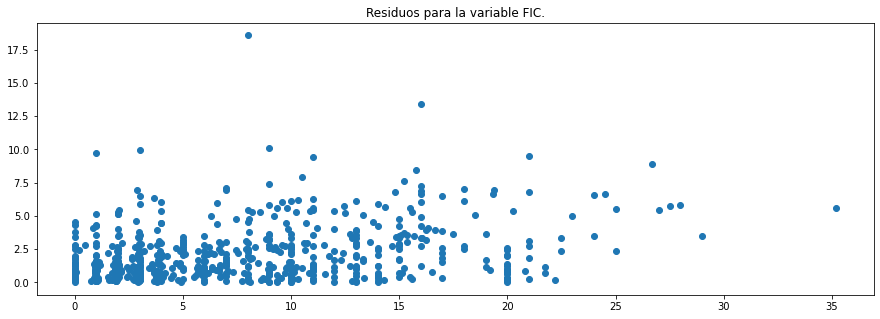

In [23]:
fig = plt.figure(figsize=(15,5))

plt.scatter(y_test_fic, abs(y_pred_fic - y_test_fic))
plt.title('Residuos para la variable FIC.')
plt.show()

Los puntos azules corresponden a los valores de residuos con respecto a la FIC.

### Para la DIC:

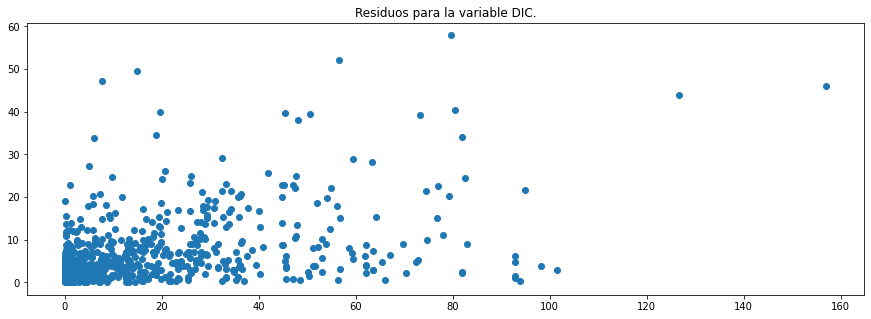

In [24]:
fig = plt.figure(figsize=(15,5))

plt.scatter(y_test_dic, abs(y_pred_dic - y_test_dic))
plt.title('Residuos para la variable DIC.')
plt.show()

Los puntos azules corresponden a los valores de residuos con respecto a la DIC.

## 7. Importancia de las variables

Utilize el metodo "Feature Importance" para determinar las 10 variables mas importante del modelo, verifique los diferentes criterios de calculo, seleccione uno y grafique sus coeficientes.

In [25]:
def features_most_important(importance_type):
    feature_importance = xgb_model.get_booster().get_score(importance_type=importance_type)
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True) # Los ordenamos de mayor a menor.
    features_most_important = feature_importance[:10] #Nos quedamos solamente con los 10 primeros.
    return features_most_important

<BarContainer object of 10 artists>

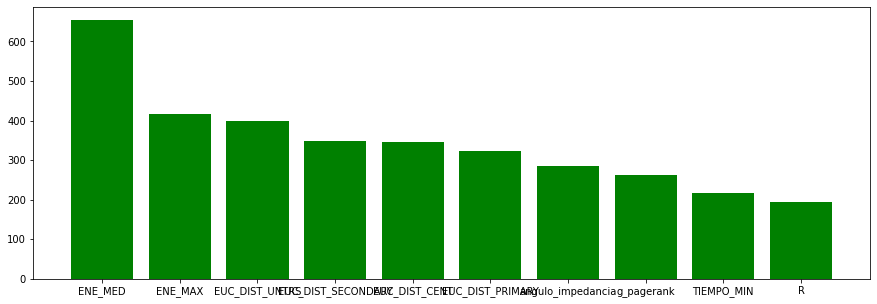

In [26]:
features_most_important = features_most_important("weight")
labels, values = zip(*features_most_important)
fig = plt.figure(figsize=(15,5))
plt.bar(labels, values, color='g')

Se pueden observar las 10 variables con mayor peso para el modelo. Cuando decimos "peso", nos referimos al tipo de importancia de las variables para el método. Para el anterior gráfico, se utilizó "weigth", que representa el número de veces que la variable se utilizó para dividir los datos en el arbol.

## 8. Clusterización

Vamos a utilizar a la clusterización como método de preprocesamiento y posteriormente vamos a correr los modelos de predicción siguiendo el artículo:

https://towardsdatascience.com/cluster-then-predict-for-classification-tasks-142fdfdc87d6


Los pasos a seguir serían:

1. Realizar la clusterización del conjunto de entrenamiento. Encontrar la cantidad de cluster óptima con el elbow method.
2. Realizar la predicción del cluster del conjunto de validación.
3. Correr el mejor algoritmo de predicción de los puntos anteriores considerando el cluster como una feature
4. Correr distintas predicciones para cada uno de los cluster: 
   + Dataset para el df[“clusters”] == 0 (clusters-0)
   + Dataset para el df[“clusters”] == 1 (clusters-1)
   +  ....
   + Dataset para el df[“clusters”] == n (clusters-n)
4. Comparar los resultados



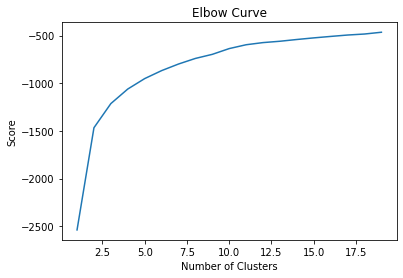

In [27]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A partir de utilizar el método del codo con el X_train, consideraremos como número de clusters el valor de 8.

In [28]:
k_means = KMeans(n_clusters=8)
k_means.fit(X_train)

KMeans()

In [29]:
X_train['cluster'] = k_means.predict(X_train)

D:\Anaconda3\envs\diplo\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
X_test['cluster'] = k_means.predict(X_test)

D:\Anaconda3\envs\diplo\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X_train, y_train_dic)

y_pred_dic = xgb_model.predict(X_test)

print('R2 score para DIC: %.2f' % r2_score(y_test_dic, y_pred_dic))

print('Error Medio Cuadrado para la DIC: %.2f' % np.sqrt(mean_squared_error(y_test_dic, y_pred_dic)))
print('Error Medio Absoluto para la DIC: %.2f' % mean_absolute_error(y_test_dic, y_pred_dic))

R2 score para DIC: 0.77
Error Medio Cuadrado para la DIC: 10.44
Error Medio Absoluto para la DIC: 6.76


In [32]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X_train, y_train_fic)

y_pred_fic = xgb_model.predict(X_test)

print('R2 score para FIC: %.2f' % r2_score(y_test_fic, y_pred_fic))

print('Error Medio Cuadrado para la FIC: %.2f' % np.sqrt(mean_squared_error(y_test_fic, y_pred_fic)))
print('Error Medio Absoluto para la FIC: %.2f' % mean_absolute_error(y_test_fic, y_pred_fic))

R2 score para FIC: 0.78
Error Medio Cuadrado para la FIC: 2.95
Error Medio Absoluto para la FIC: 2.13


In [33]:
# Para la búsqueda de los mejores parámetros para la FIC, usamos usar:
exploring_params = { 
                      'learning_rate': [0.01, 0.1],
                      'max_depth': [3, 5, 7, 10],
                      'min_child_weight': [1, 3, 5],
                      'subsample': [0.5, 0.7],
                      'colsample_bytree': [0.5, 0.7],
                      'n_estimators' : [100, 200, 500],
                      'objective': ['reg:squarederror']
                    }


m = xgb.XGBRegressor()
model = GridSearchCV(m, exploring_params)
    
model.fit(X_train, y_train_fic)

print("Mejor conjunto de parámetros para la FIC:")
print(model.best_params_, end="\n\n")
y_predicted_fic = model.predict(X_test)
print("R2 score para el mejor clasificador para la FIC: %.2f" % r2_score(y_test_fic, y_predicted_fic))
print('Error Medio Cuadrado para la FIC: %.2f' % np.sqrt(mean_squared_error(y_test_fic, y_predicted_fic)))
print('Error Medio Absoluto para la FIC: %.2f' % mean_absolute_error(y_test_fic, y_predicted_fic))
print("================================================", end="\n\n")

Mejor conjunto de parámetros para la FIC:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7}

R2 score para el mejor clasificador para la FIC: 0.82
Error Medio Cuadrado para la FIC: 2.64
Error Medio Absoluto para la FIC: 1.89



In [34]:
# Para la búsqueda de los mejores parámetros para la DIC, usamos usar:
exploring_params = { 
                      'learning_rate': [0.01, 0.1],
                      'max_depth': [3, 5, 7, 10],
                      'min_child_weight': [1, 3, 5],
                      'subsample': [0.5, 0.7],
                      'colsample_bytree': [0.5, 0.7],
                      'n_estimators' : [100, 200, 500],
                      'objective': ['reg:squarederror']
                    }


m = xgb.XGBRegressor()
model = GridSearchCV(m, exploring_params)
    
model.fit(X_train, y_train_dic)

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")
y_predicted_dic = model.predict(X_test)
print("R2 score para el mejor clasificador para la DIC: %.2f" % r2_score(y_test_dic, y_predicted_dic))
print('Error Medio Cuadrado para la DIC: %.2f' % np.sqrt(mean_squared_error(y_test_dic, y_predicted_dic)))
print('Error Medio Absoluto para la DIC: %.2f' % mean_absolute_error(y_test_dic, y_predicted_dic))
print("================================================", end="\n\n")

Mejor conjunto de parámetros:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.7}

R2 score para el mejor clasificador para la DIC: 0.81
Error Medio Cuadrado para la DIC: 9.61
Error Medio Absoluto para la DIC: 6.20



## 9. Conclusiones

Luego de haber probado con diferentes algoritmos de predicción, creemos que el mejor a aplicar es el XGBRegressor. Para poder mejorar su precisión tuvimos que agregarle una variable a nuestro set de datos, obtenida del proceso de clusterización. Si bien no sumó mucho a la precisión pero vale la pena mantenerla. En la clusterización usamos el método del "codo" para obtener la cantidad de cluster(ocho en este caso), pero cabe destacar que se podría probar con un número diferente y ver como la precisión del modelo varía. Es decir si mejora o empeoran los resultados. En nuestro caso probamos con un valor menor a ocho, con seis pero nuestra precisión decrementó, por tal motivo decidimos dejarlo en ocho a la cantidad de clusters. además tuvimos que probar con diferentes hyper parámetros para poder definir los mejores que se adapten a nuestro set de datos y que tengan una mayor precisión. Gracias a esto úñtimo pudimos elevar la precision para 0.80 (para el caso de la FIC) y 0.76(para el caso de la DIC).

Con respecto a la regresión lineal, el modelo que se obtuvo posee variables con pesos negativos. Esto produce que algunas predicciones para la FIC y la DIC, sean negativas. Por este motivo a los residuos los mostramos realizando la resta en valor absoluto. Viendo esto podemos descartar la utilización de este modelo.

Otro tema que enfrentamos fue que nos dimos cuenta que nuestro dataset contenía errores en los datos de las columnas FIC y DIC. Había valores muy grandes, ya que estos se calcularon como resultado de la suma de todos los usuarios conectados a un transforamodr (recordar que cada fila de nuestro dataset actual representa un transformador untrd). Procedimos a corregirlo en los trabajos anteriores, lo que hicimos fue que no se calcule como una suma, si no como un promedio. Haciendo esta correción los valores de la precisión de los modelos aumentaron, ya que en un principio daban valores muy bajos.